###**Mounting Google Drive**

In [473]:
# from google.colab import drive
# drive.mount('/content/drive')

In [474]:
rand_state=42

###**Import Libraries**

In [475]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold,cross_val_score,KFold,StratifiedKFold
from sklearn.metrics import accuracy_score,f1_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [476]:
from numpy.random import seed
seed(42)
tf.random.set_seed(42)

In [477]:
from sklearn.metrics import confusion_matrix
def plot_conf_matrix(y_test,y_pred,uniqueclassLabel, title="CMatrix"):
  cm = confusion_matrix(y_true=y_test,y_pred=y_pred,labels=uniqueclassLabel)
  plt.figure(figsize=(5,4))
  plt.title(title)
  #ax = plt.subplot()
  sns.heatmap(cm, annot=True,cmap='Blues',
              yticklabels=uniqueclassLabel,xticklabels=uniqueclassLabel,fmt='3g')

###**Import Utility File**

In [478]:
user = 'nishitgala89'
repo = 'ProjectDissertation'
src_dir = "Code/utilities"
pyfile = "morningStarUtilities.py"

url = f"https://raw.githubusercontent.com/{user}/{repo}/main/{src_dir}/{pyfile}"
!wget --no-cache --backups=1 {url}

import morningStarUtilities

--2022-01-06 14:25:05--  https://raw.githubusercontent.com/nishitgala89/ProjectDissertation/main/Code/utilities/morningStarUtilities.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6484 (6.3K) [text/plain]
Saving to: ‘morningStarUtilities.py’

morningStarUtilitie 100%[===================>]   6.33K  --.-KB/s    in 0s      

2022-01-06 14:25:05 (45.8 MB/s) - ‘morningStarUtilities.py’ saved [6484/6484]



### **Import Training Data**

In [479]:
# uploaded = files.upload()
# train_df = pd.read_csv(io.BytesIO(uploaded['morningstar_removedDuplicates_train_withoutM60.csv']))

In [480]:
train_df = pd.read_csv("https://raw.githubusercontent.com/nishitgala89/ProjectDissertation/main/Datasheets/3_Modelling/morningstar_removedDuplicates_train_withoutLogTransform_withoutM60.csv").set_index("SecId")

### **Import Testing Data**

In [481]:
# uploaded = files.upload()
# test_df = pd.read_csv(io.BytesIO(uploaded['morningstar_removedDuplicates_test_withoutM60.csv']))

In [482]:
test_df = pd.read_csv('https://raw.githubusercontent.com/nishitgala89/ProjectDissertation/main/Datasheets/3_Modelling/morningstar_removedDuplicates_test_withoutLogTransform_withoutM60.csv').set_index("SecId")

### **Defining Training, Testing varibales**

In [483]:
train_df['Ratings_reset'] = train_df['StarRatingM255'].apply(lambda x : 2 if(x in (1,2)) else (4 if(x in (4,5)) else 3))
test_df['Ratings_reset'] = test_df['StarRatingM255'].apply(lambda x : 2 if(x in (1,2)) else (4 if(x in (4,5)) else 3))

In [484]:
imp_features = ['SustainabilityRank','GBRReturnM1','GBRReturnM3','GBRReturnM0','GBRReturnM36','OngoingCostActual','TransactionFeeActual','FundTNAV',
'AverageMarketCapital','MorningstarRiskM255','AlphaM36','BetaM36','StandardDeviationM36','SharpeM36','Size','Style']
X_train = train_df[imp_features]
y_train = train_df[['Ratings_reset']]

X_test = test_df[imp_features]
y_test = test_df['Ratings_reset']

In [485]:
y_train = y_train.astype('string')

In [486]:
from sklearn.preprocessing import OneHotEncoder
y_train_cat = OneHotEncoder().fit_transform(y_train[["Ratings_reset"]]).toarray()
y_train_cat.shape

(886, 3)

In [487]:
y_train_cat

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

In [488]:
train_df.nunique()

Name                         886
StarRatingM255                 5
SustainabilityRank             5
Yield_M12                    364
GBRReturnW1                  292
GBRReturnM1                  544
GBRReturnM3                  543
GBRReturnM6                  716
GBRReturnM0                  691
GBRReturnM12                 780
GBRReturnM36                 660
MaxFrontEndLoad               22
OngoingCostActual            227
TransactionFeeActual         126
ManagerTenure                230
FundTNAV                     691
AverageMarketCapital         690
MorningstarRiskM255            5
AlphaM36                     624
BetaM36                       97
R2M36                        669
StandardDeviationM36         604
SharpeM36                    127
ReturnProfilePreservation      3
ReturnProfileIncome            3
ReturnProfileHedging           3
TrackRecordExtension           2
Cat_Flex-Cap                   2
Cat_Income                     2
Cat_Large-Cap                  2
Cat_Mid_Sm

In [489]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 886 entries, F000005ETU to F00000M89N
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Ratings_reset  886 non-null    string
dtypes: string(1)
memory usage: 13.8+ KB


In [490]:
# y_train = y_train.astype('category')
# y_test = y_test.astype('category')

In [491]:
X_train.shape, y_train.shape

((886, 16), (886, 1))

In [492]:
X_test.shape,y_test.shape

((296, 16), (296,))

### **Scaling the Data**

In [493]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### **Creating runtime variables**

In [494]:
unique_class_label = list(train_df.Ratings_reset.unique())
unique_class_label.sort()
unique_class_label

[2, 3, 4]

### **Defining Neural Network Model**

In [495]:
# Number of Hidden Layers
round((X_train.shape[1] + len(unique_class_label))/2) + 1

11

### Method 1 - Using Scikit Learn - KerasClassifier


In [496]:
# def baseline_model():    
#   network = Sequential()
#   network.add(tf.keras.layers.Dense(units=11,activation ='relu', input_dim = X_train.shape[1] ))
#   network.add(tf.keras.layers.Dropout(0.2))
#   network.add(tf.keras.layers.Dense(units=11,activation ='relu'))
#   network.add(tf.keras.layers.Dropout(0.2))
#   network.add(tf.keras.layers.Dense(units=11,activation ='relu'))
#   network.add(tf.keras.layers.Dropout(0.2))
#   network.add(tf.keras.layers.Dense(3,activation='softmax'))
#   network.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
#   return network

In [497]:
# from keras.wrappers.scikit_learn import KerasClassifier
# estimator = KerasClassifier(build_fn = baseline_model, epochs = 10, batch_size = 10, verbose = -1)

In [498]:
# skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
# results = cross_val_score(estimator, X_train_scaled, y_train, cv = skf)

# print(results)
# print("Result: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [499]:
# y_pred = estimator.predict(X_test_scaled)

In [500]:
# plot_conf_matrix(y_test,y_pred,unique_class_label, title="Confusion Matrix for " + clf.__class__.__name__)
# print("Accuracy Score for " +  estimator.__class__.__name__ + "  " 
#         + str(accuracy_score(y_test,y_pred)) )
# print("F1 Score for " + estimator.__class__.__name__ + "  " + 
#         str(f1_score(y_test, y_pred, average='weighted')))

### Method 2 - Using Sequential Model

In [501]:
model = Sequential()
model.add(tf.keras.layers.Dense(units=11,activation ='relu', input_shape = (len(imp_features),) ))
model.add(tf.keras.layers.Dropout(0.2))
# model.add(tf.keras.layers.Dense(units=8,activation ='relu'))
# model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(units=6,activation ='relu'))
model.add(tf.keras.layers.Dropout(0.2))
# model.add(tf.keras.layers.Dense(units=5,activation ='relu'))
# model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(units=3,activation='softmax'))
model.compile(optimizer = Adam(), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [502]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 11)                187       
                                                                 
 dropout_16 (Dropout)        (None, 11)                0         
                                                                 
 dense_25 (Dense)            (None, 6)                 72        
                                                                 
 dropout_17 (Dropout)        (None, 6)                 0         
                                                                 
 dense_26 (Dense)            (None, 3)                 21        
                                                                 
Total params: 280
Trainable params: 280
Non-trainable params: 0
_________________________________________________________________


In [503]:
X_train_scaled.shape, y_train.shape

((886, 16), (886, 1))

In [504]:
history = model.fit(X_train_scaled,y_train_cat,validation_split=0.30,epochs=300, verbose=1,batch_size=50)

Epoch 1/300
13/13 [==============================] - 1s 23ms/step - loss: 1.2791 - accuracy: 0.3823 - val_loss: 1.1381 - val_accuracy: 0.4060
Epoch 2/300
13/13 [==============================] - 0s 6ms/step - loss: 1.2483 - accuracy: 0.3661 - val_loss: 1.1005 - val_accuracy: 0.4135
Epoch 3/300
13/13 [==============================] - 0s 6ms/step - loss: 1.2227 - accuracy: 0.3452 - val_loss: 1.0703 - val_accuracy: 0.4173
Epoch 4/300
13/13 [==============================] - 0s 5ms/step - loss: 1.1534 - accuracy: 0.3742 - val_loss: 1.0473 - val_accuracy: 0.4173
Epoch 5/300
13/13 [==============================] - 0s 6ms/step - loss: 1.1568 - accuracy: 0.3645 - val_loss: 1.0291 - val_accuracy: 0.4436
Epoch 6/300
13/13 [==============================] - 0s 6ms/step - loss: 1.1081 - accuracy: 0.3968 - val_loss: 1.0160 - val_accuracy: 0.4586
Epoch 7/300
13/13 [==============================] - 0s 6ms/step - loss: 1.1008 - accuracy: 0.4000 - val_loss: 1.0044 - val_accuracy: 0.4737
Epoch 8/300


### Plot Loss and Accuracy

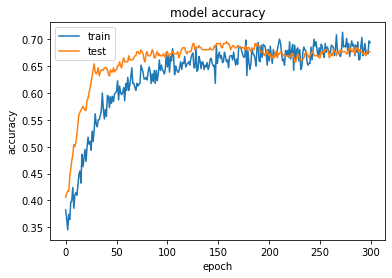

In [505]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

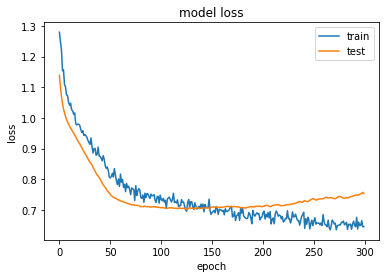

In [506]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [507]:
y_pred = model.predict(X_test_scaled)

In [508]:
y_pred

array([[8.41787279e-01, 1.58212587e-01, 1.15664690e-07],
       [4.40728449e-08, 1.33701544e-02, 9.86629844e-01],
       [4.04923975e-01, 5.51540017e-01, 4.35359702e-02],
       [1.19631581e-01, 4.28196669e-01, 4.52171803e-01],
       [3.75910074e-01, 5.77033699e-01, 4.70562615e-02],
       [4.46827859e-02, 5.92685640e-01, 3.62631589e-01],
       [4.12875740e-03, 3.68057787e-01, 6.27813518e-01],
       [1.13143763e-02, 3.30203474e-01, 6.58482134e-01],
       [6.06182039e-01, 3.93043816e-01, 7.74043787e-04],
       [4.98566260e-05, 8.41209516e-02, 9.15829182e-01],
       [3.28473449e-02, 3.82992059e-01, 5.84160566e-01],
       [4.97228503e-02, 6.97603106e-01, 2.52674073e-01],
       [1.42768234e-01, 7.78253257e-01, 7.89784938e-02],
       [6.40728569e-04, 1.15582541e-01, 8.83776724e-01],
       [3.18830833e-02, 5.16602635e-01, 4.51514244e-01],
       [6.61426842e-01, 3.38385552e-01, 1.87689075e-04],
       [9.81544614e-01, 1.84553564e-02, 1.59689529e-14],
       [4.48435545e-03, 2.84898

In [509]:
y_pred = np.argmax(y_pred, axis=1)

In [510]:
y_pred = y_pred + 2 # Ratings are 2,3,4

In [511]:
y_pred

array([2, 4, 3, 4, 3, 3, 4, 4, 2, 4, 4, 3, 3, 4, 3, 2, 2, 4, 2, 4, 4, 2,
       2, 2, 4, 3, 3, 3, 4, 4, 2, 2, 4, 3, 3, 2, 2, 4, 2, 3, 4, 2, 4, 2,
       4, 4, 2, 3, 2, 2, 4, 2, 4, 2, 4, 3, 2, 4, 2, 4, 3, 4, 4, 4, 2, 4,
       4, 4, 4, 3, 2, 2, 3, 4, 3, 4, 4, 2, 4, 4, 4, 4, 4, 3, 3, 3, 3, 4,
       3, 4, 2, 4, 4, 4, 3, 3, 4, 3, 2, 2, 3, 3, 4, 2, 3, 4, 4, 3, 3, 2,
       3, 2, 4, 4, 4, 4, 4, 3, 2, 3, 2, 2, 3, 3, 4, 3, 4, 4, 4, 2, 4, 3,
       3, 2, 2, 3, 4, 4, 2, 3, 4, 2, 4, 2, 2, 3, 2, 2, 4, 4, 3, 4, 4, 2,
       2, 2, 3, 4, 3, 4, 4, 3, 3, 2, 4, 4, 2, 3, 4, 3, 2, 3, 2, 3, 4, 3,
       2, 4, 3, 3, 3, 4, 3, 2, 4, 4, 3, 4, 4, 4, 4, 2, 2, 3, 2, 3, 3, 4,
       4, 3, 3, 3, 4, 4, 3, 2, 4, 4, 4, 2, 4, 4, 4, 3, 3, 4, 3, 3, 4, 2,
       4, 3, 4, 4, 2, 3, 3, 2, 3, 4, 4, 3, 3, 4, 4, 2, 4, 2, 4, 4, 4, 4,
       2, 4, 2, 4, 4, 2, 2, 3, 4, 3, 3, 4, 4, 4, 2, 2, 4, 2, 2, 4, 3, 3,
       2, 4, 3, 4, 2, 4, 2, 2, 3, 4, 4, 3, 2, 4, 2, 3, 4, 4, 4, 4, 2, 2,
       3, 3, 2, 2, 3, 2, 3, 3, 2, 4])

In [512]:
y_test.values

array([3, 4, 2, 3, 3, 3, 4, 4, 3, 4, 4, 3, 4, 4, 3, 2, 2, 4, 3, 4, 4, 3,
       2, 2, 4, 3, 4, 2, 4, 4, 2, 2, 4, 3, 2, 2, 3, 4, 2, 4, 4, 2, 4, 3,
       4, 4, 3, 3, 2, 2, 3, 2, 4, 3, 4, 2, 2, 4, 2, 4, 4, 4, 4, 4, 2, 4,
       4, 4, 3, 2, 3, 2, 4, 3, 2, 3, 4, 2, 4, 4, 2, 4, 4, 3, 3, 3, 2, 4,
       3, 4, 2, 3, 3, 3, 3, 2, 4, 2, 2, 2, 4, 4, 4, 3, 3, 4, 4, 3, 3, 3,
       3, 2, 4, 4, 4, 4, 4, 3, 2, 3, 2, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 2,
       3, 2, 2, 3, 3, 3, 2, 4, 4, 3, 3, 2, 3, 3, 3, 2, 4, 4, 4, 3, 3, 2,
       2, 2, 3, 3, 4, 4, 4, 2, 3, 2, 4, 4, 2, 3, 4, 4, 2, 4, 2, 2, 4, 3,
       2, 4, 3, 3, 3, 4, 3, 2, 4, 4, 3, 3, 4, 3, 4, 2, 3, 3, 4, 2, 3, 4,
       4, 3, 4, 3, 4, 4, 2, 2, 4, 3, 3, 2, 3, 3, 4, 2, 4, 3, 2, 3, 4, 2,
       3, 4, 3, 3, 2, 2, 4, 2, 4, 4, 3, 2, 3, 4, 4, 2, 4, 2, 4, 4, 4, 3,
       3, 4, 2, 4, 4, 2, 2, 2, 4, 2, 4, 3, 4, 4, 2, 3, 3, 2, 3, 3, 4, 3,
       2, 4, 3, 4, 2, 4, 2, 2, 3, 4, 4, 3, 2, 4, 2, 2, 3, 3, 4, 4, 2, 2,
       3, 2, 3, 4, 4, 2, 3, 3, 3, 4])

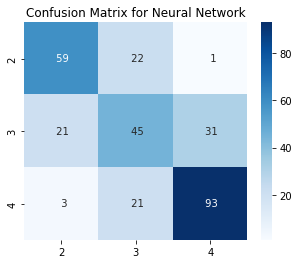

In [513]:
plot_conf_matrix(y_test.values,y_pred,unique_class_label, title="Confusion Matrix for Neural Network" )

In [514]:
print("Accuracy Score for " +  model.__class__.__name__ + "  " 
        + str(accuracy_score(y_test.values,y_pred)) )
print("F1 Score for " + model.__class__.__name__ + "  " + 
        str(f1_score(y_test.values, y_pred, average='weighted')))

Accuracy Score for Sequential  0.6655405405405406
F1 Score for Sequential  0.6613420042781223


In [515]:
model_json = model.to_json()
with open('/content/model.json','w') as json_file:
  json_file.write(model_json)

In [516]:
from keras.models import save_model
model_weights = save_model(model, '/content/model_weights.hdf5')

#### Performing testing using Loaded model

In [517]:
with open('/content/model.json', 'r') as json_file:
  json_saved_model = json_file.read()
json_saved_model

'{"class_name": "Sequential", "config": {"name": "sequential_8", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 16], "dtype": "float32", "sparse": false, "ragged": false, "name": "dense_24_input"}}, {"class_name": "Dense", "config": {"name": "dense_24", "trainable": true, "batch_input_shape": [null, 16], "dtype": "float32", "units": 11, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "Dropout", "config": {"name": "dropout_16", "trainable": true, "dtype": "float32", "rate": 0.2, "noise_shape": null, "seed": null}}, {"class_name": "Dense", "config": {"name": "dense_25", "trainable": true, "dtype": "float32", "units": 6, "activation": "relu", "use_bias": true, "kernel_initializ

In [518]:
network_loaded = tf.keras.models.model_from_json(json_saved_model)
network_loaded.load_weights('model_weights.hdf5')
network_loaded.compile(loss = 'categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [519]:
y_pred_loaded = network_loaded.predict(X_test_scaled)

In [520]:
y_pred_loaded = np.argmax(y_pred_loaded, axis=1)

In [521]:
y_pred_loaded +=2

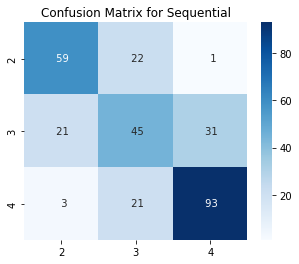

In [522]:
plot_conf_matrix(y_test.values,y_pred_loaded,unique_class_label, title="Confusion Matrix for " + model.__class__.__name__)

#### Prediction on Asia Developed Dataset

In [523]:
asia_df = pd.read_csv('https://raw.githubusercontent.com/nishitgala89/ProjectDissertation/main/Datasheets/3_Modelling/Generalization_Check_Asia_Developed.csv').set_index("SecId")
asia_df = morningStarUtilities.createSize_InvestmentTypeFeature(asia_df)
asia_df['Ratings_reset'] = asia_df['StarRatingM255'].apply(lambda x : 2 if(x in (1,2)) else (4 if(x in (4,5)) else 3))

In [524]:
asia_df[asia_df.FundTNAV.isnull()]

,Name,StarRatingM255,SustainabilityRank,CategoryName,Yield_M12,GBRReturnW1,GBRReturnM1,GBRReturnM3,GBRReturnM6,GBRReturnM0,GBRReturnM12,GBRReturnM36,GBRReturnM60,MaxFrontEndLoad,OngoingCostActual,TransactionFeeActual,ManagerTenure,FundTNAV,EquityStyleBox,AverageMarketCapital,MorningstarRiskM255,AlphaM36,BetaM36,R2M36,StandardDeviationM36,SharpeM36,ReturnProfilePreservation,ReturnProfileIncome,ReturnProfileHedging,TrackRecordExtension,Size,Style,Ratings_reset
SecId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
F00001071Q,BIEF Emerging Markets A GBP Acc,4,2,Global Emerging Markets Equity,0.62047,1.43,1.64,-3.35,-7.72,0.09,10.79,10.05,NaN,NaN,1.12,1.17,24.08,NaN,2,28614.24791,4,2.47,1.02,89.7,16.24,0.66,3,1,3.0,False,1,2,4


In [525]:
asia_df.drop(index='F00001071Q',inplace=True)


In [526]:
X_asia = asia_df[imp_features]
y_asia = asia_df['Ratings_reset']
X_asia_scaled = scaler.transform(X_asia)

In [527]:
y_asia_pred = network_loaded.predict(X_asia_scaled)
y_asia_pred = np.argmax(y_asia_pred, axis=1)
y_asia_pred += 2

In [528]:
y_asia.shape

(432,)

In [529]:
y_asia_pred.shape

(432,)

In [530]:
print("Accuracy Score for " +  model.__class__.__name__ + "  " 
        + str(accuracy_score(y_asia.values,y_asia_pred)) )
print("F1 Score for " + model.__class__.__name__ + "  " + 
        str(f1_score(y_asia.values, y_asia_pred, average='weighted')))

Accuracy Score for Sequential  0.5416666666666666
F1 Score for Sequential  0.4859170192320316


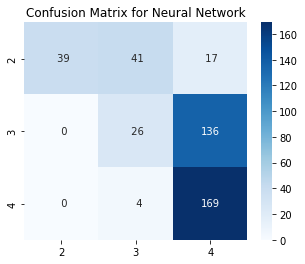

In [531]:
plot_conf_matrix(y_asia.values,y_asia_pred,unique_class_label, title="Confusion Matrix for Neural Network" )